# FAIM SDK Example: ToTo Probabilistic Forecasting with Sunspots Dataset

This notebook demonstrates how to use the FAIM SDK to generate **probabilistic forecasts** using the ToTo model.

**Dataset**: Sunspots - Annual sunspot activity observations (1700-2008)

**ToTo Features**:
- Quantile predictions for uncertainty estimation
- Sample-based forecasting
- Multi-series forecasting support

## 1. Setup and Installation

In [11]:
# Install dependencies if needed
# !pip install numpy pandas matplotlib statsmodels

In [12]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import FAIM SDK
from faim_sdk import ForecastClient, ToToForecastRequest
from faim_client.models import ModelName

## 2. Load Sunspots Dataset

In [13]:
# Load Sunspots dataset from statsmodels
import statsmodels.api as sm

sunspots_data = sm.datasets.sunspots.load_pandas()
df = sunspots_data.data

print("✓ Dataset loaded successfully")
print(f"  Dataset: Yearly sunspots (1700-2008)")
print(f"  Shape: {df.shape}")
print(f"\nDataset preview:")
print(df.head())

✓ Dataset loaded successfully
  Dataset: Yearly sunspots (1700-2008)
  Shape: (309, 2)

Dataset preview:
     YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0


## 3. Data Preprocessing

Time series length: 309
Value range: [0.0, 190.2]


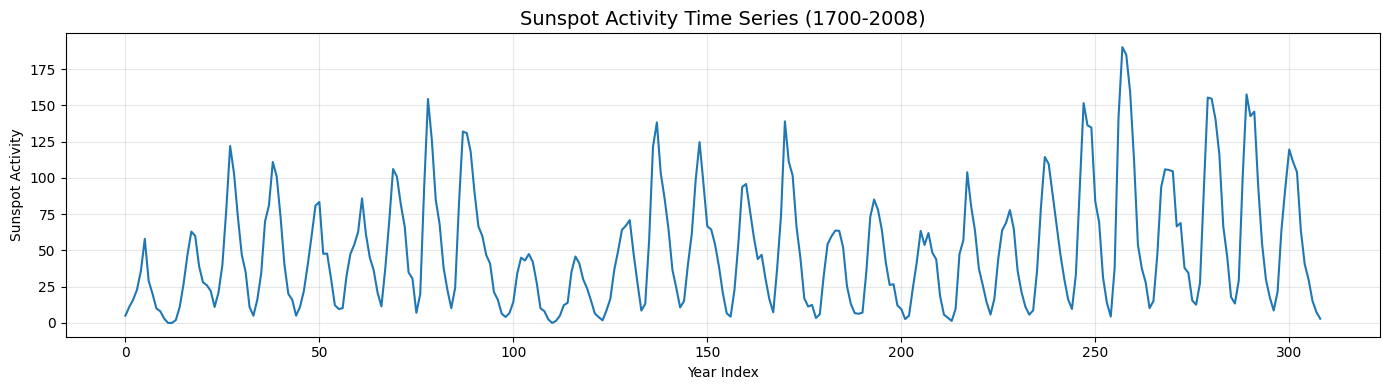

In [14]:
# Extract sunspot activity as numpy array
sunspots = df['SUNACTIVITY'].values.astype(np.float32)

print(f"Time series length: {len(sunspots)}")
print(f"Value range: [{sunspots.min():.1f}, {sunspots.max():.1f}]")

# Visualize the time series
plt.figure(figsize=(14, 4))
plt.plot(sunspots)
plt.title('Sunspot Activity Time Series (1700-2008)', fontsize=14)
plt.xlabel('Year Index')
plt.ylabel('Sunspot Activity')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Prepare data for forecasting
# ToTo expects shape: (batch_size, sequence_length, features)

context_length = 100
horizon = 10

# Use data from index -110 to -10 for context
x = sunspots[-context_length-horizon:-horizon].reshape(1, context_length, 1)

# Ground truth for comparison (last 10 years)
y_true = sunspots[-horizon:]

print(f"Input shape: {x.shape}")
print(f"Context period: {context_length} years")
print(f"Forecasting {horizon} years ahead")
print(f"Ground truth available: {len(y_true)} points")

Input shape: (1, 100, 1)
Context period: 100 years
Forecasting 10 years ahead
Ground truth available: 10 points


## 4. Initialize FAIM Client

In [16]:
# Initialize the client
# TODO: Replace with your actual FAIM API endpoint and API key
BASE_URL = "http://localhost:8003"  # Example: "https://api.faim.example.com"
FAIM_API_KEY = os.environ["FAIM_API_KEY"]  # Example: "your-secret-api-key"

client = ForecastClient(
    base_url=BASE_URL,
    api_key=FAIM_API_KEY,  # Optional: API key for authentication
    timeout=60.0,
    verify_ssl=True
)

print(f"✓ ForecastClient initialized: {BASE_URL}")
if FAIM_API_KEY:
    print("  Authentication: Enabled")
else:
    print("  Authentication: Disabled")

✓ ForecastClient initialized: http://localhost:8003
  Authentication: Enabled


## 5. Create ToTo Forecast Request

ToTo supports **quantile predictions** for probabilistic forecasting. We'll request:
- 10th percentile (lower bound)
- 50th percentile (median)
- 90th percentile (upper bound)

In [17]:
# Create ToTo forecast request with quantiles
request = ToToForecastRequest(
    x=x,
    horizon=horizon,
    model_version="1",
    # output_type="quantiles",  # Request quantile predictions
    output_type="point",  # Request quantile predictions
    quantiles=[0.1, 0.5, 0.9],  # 10th, 50th (median), 90th percentiles
    compression="zstd"
)

print("Request created:")
print(f"  - Input shape: {request.x.shape}")
print(f"  - Horizon: {request.horizon}")
print(f"  - Output type: {request.output_type}")
print(f"  - Quantiles: {request.quantiles}")
print(f"  - Model version: {request.model_version}")

Request created:
  - Input shape: (1, 100, 1)
  - Horizon: 10
  - Output type: point
  - Quantiles: [0.1, 0.5, 0.9]
  - Model version: 1


## 6. Generate Probabilistic Forecast

In [18]:
try:
    # Make forecast request
    response = client.forecast(ModelName.TOTO, request)
    
    print("✓ Forecast successful!")
    print(f"\nResponse: {response}")
    print(f"\nResponse details:")
    print(f"  - Point shape: {response.point.shape if response.point is not None else None}")
    print(f"  - Quantiles shape: {response.quantiles.shape if response.quantiles is not None else None}")
    print(f"  - Samples shape: {response.samples.shape if response.samples is not None else None}")
    print(f"  - Metadata: {response.metadata}")
    
except Exception as e:
    print(f"✗ Forecast failed: {e}")
    print(f"\nError type: {type(e).__name__}")
    if hasattr(e, 'details'):
        print(f"Details: {e.details}")
    raise

✓ Forecast successful!

Response: ForecastResponse(outputs=[point.shape=(1, 256)], metadata={'model_name': 'toto', 'model_version': '1', 'transaction_id': '7b1f61f4-b587-4651-980e-82288ccd5cbd', 'cost_amount': 150000, 'cost_currency': 'USD'})

Response details:
  - Point shape: (1, 256)
  - Quantiles shape: None
  - Samples shape: None
  - Metadata: {'model_name': 'toto', 'model_version': '1', 'transaction_id': '7b1f61f4-b587-4651-980e-82288ccd5cbd', 'cost_amount': 150000, 'cost_currency': 'USD'}


In [19]:
# Extract predictions based on what ToTo returned
# ToTo can return: point predictions, quantiles, or samples

if response.quantiles is not None:
    # Quantile predictions available - extract percentiles
    # Shape: (batch_size, horizon, num_quantiles)
    print(f"Using quantile predictions")
    q10 = response.quantiles[0, :horizon, 0]  # 10th percentile
    median = response.quantiles[0, :horizon, 1]  # 50th percentile (median)
    q90 = response.quantiles[0, :horizon, 2]  # 90th percentile
    
    print(f"  - 10th percentile shape: {q10.shape}")
    print(f"  - Median shape: {median.shape}")
    print(f"  - 90th percentile shape: {q90.shape}")

elif response.point is not None:
    # Point predictions (deterministic forecast)
    print(f"Using point predictions")
    # Extract only the horizon length we need
    predictions_flat = response.point.flatten()
    median = predictions_flat[:horizon]  # Take only first 'horizon' values
    q10 = None
    q90 = None
    print(f"  - Point predictions shape: {median.shape}")
    print(f"  - Note: Server returned {len(predictions_flat)} values, using first {horizon}")

elif response.samples is not None:
    # Sample-based predictions - compute statistics
    print(f"Using sample predictions")
    samples = response.samples[0, :horizon, :]  # Shape: (horizon, num_samples)
    median = np.median(samples, axis=1)
    q10 = np.percentile(samples, 10, axis=1)
    q90 = np.percentile(samples, 90, axis=1)
    
    print(f"  - Median shape: {median.shape}")
    print(f"  - 10th percentile shape: {q10.shape}")
    print(f"  - 90th percentile shape: {q90.shape}")

else:
    raise ValueError("No predictions found in response")

Using point predictions
  - Point predictions shape: (10,)
  - Note: Server returned 256 values, using first 10


## 7. Visualize Probabilistic Forecast

Show the median prediction with uncertainty bands (10th-90th percentile)

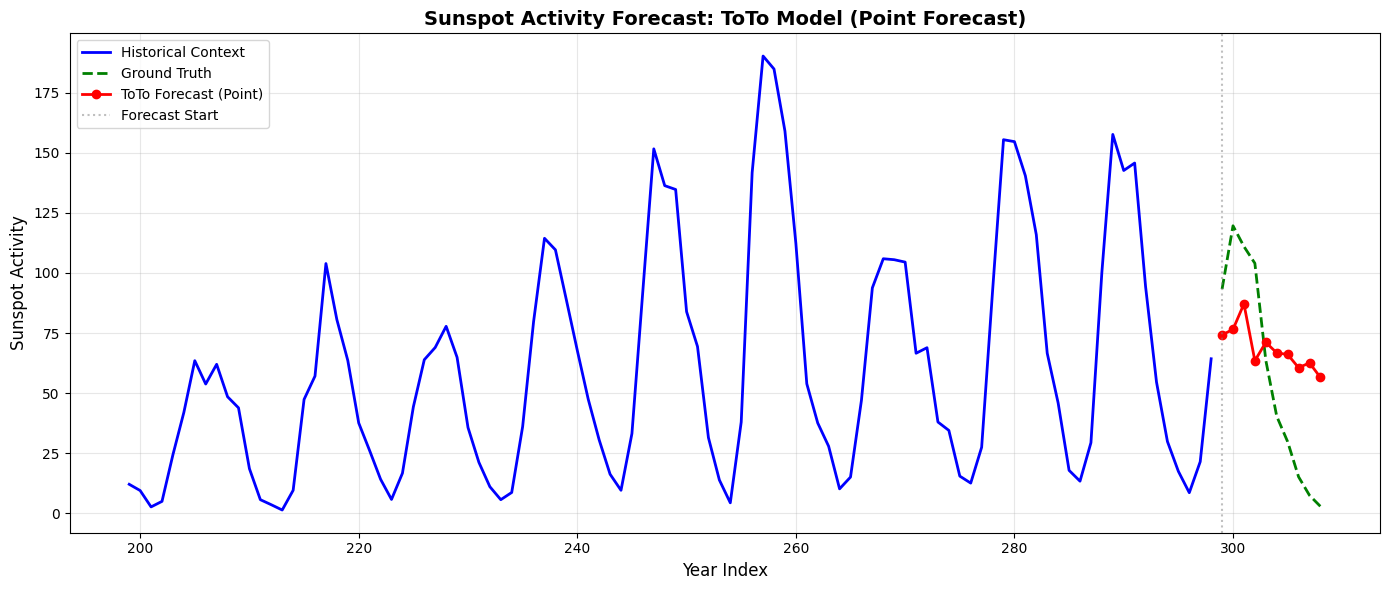

In [20]:
# Plot forecast with uncertainty bands
plt.figure(figsize=(14, 6))

# Historical data (context)
historical_start = len(sunspots) - context_length - horizon
plt.plot(range(historical_start, historical_start + context_length), 
         sunspots[-context_length-horizon:-horizon], 
         label='Historical Context', color='blue', linewidth=2)

# Ground truth (actual future values)
forecast_indices = range(historical_start + context_length, historical_start + context_length + horizon)
plt.plot(forecast_indices, y_true,
         label='Ground Truth', color='green', linewidth=2, linestyle='--')

# Median prediction
forecast_label = 'ToTo Forecast (Median)' if q10 is not None else 'ToTo Forecast (Point)'
plt.plot(forecast_indices, median,
         label=forecast_label, color='red', linewidth=2, marker='o')

# Uncertainty bands (if available)
if q10 is not None and q90 is not None:
    plt.fill_between(forecast_indices, q10, q90, 
                     color='red', alpha=0.2, label='80% Prediction Interval')

# Formatting
plt.axvline(x=historical_start + context_length, color='gray', linestyle=':', alpha=0.5, label='Forecast Start')
title_suffix = ' with Uncertainty' if q10 is not None else ' (Point Forecast)'
plt.title(f'Sunspot Activity Forecast: ToTo Model{title_suffix}', fontsize=14, fontweight='bold')
plt.xlabel('Year Index', fontsize=12)
plt.ylabel('Sunspot Activity', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Evaluate Forecast Accuracy

In [21]:
# Calculate error metrics using median prediction
mae = np.mean(np.abs(median - y_true))
rmse = np.sqrt(np.mean((median - y_true) ** 2))
mape = np.mean(np.abs((median - y_true) / (y_true + 1e-8))) * 100

print("Forecast Accuracy Metrics (Median):")
print(f"  MAE (Mean Absolute Error):        {mae:.2f}")
print(f"  RMSE (Root Mean Squared Error):   {rmse:.2f}")
print(f"  MAPE (Mean Absolute % Error):     {mape:.2f}%")

# Check prediction interval coverage (if quantiles available)
if q10 is not None and q90 is not None:
    # How many actual values fall within the 80% prediction interval?
    in_interval = np.sum((y_true >= q10) & (y_true <= q90))
    coverage = (in_interval / len(y_true)) * 100
    print(f"\nPrediction Interval Coverage:")
    print(f"  80% interval coverage: {coverage:.1f}% ({in_interval}/{len(y_true)} points)")
    print(f"  Expected: ~80%")

Forecast Accuracy Metrics (Median):
  MAE (Mean Absolute Error):        35.07
  RMSE (Root Mean Squared Error):   38.03
  MAPE (Mean Absolute % Error):     319.77%


In [22]:
# Point-by-point comparison with uncertainty
if q10 is not None and q90 is not None:
    comparison_df = pd.DataFrame({
        'Year': range(1, horizon + 1),
        'Ground Truth': y_true,
        'Median Forecast': median,
        '10th Percentile': q10,
        '90th Percentile': q90,
        'Error': median - y_true,
        'In Interval': ((y_true >= q10) & (y_true <= q90)).astype(str)
    })
else:
    comparison_df = pd.DataFrame({
        'Year': range(1, horizon + 1),
        'Ground Truth': y_true,
        'Forecast': median,
        'Error': median - y_true,
    })

print("\nPoint-by-point comparison:")
print(comparison_df.to_string(index=False))


Point-by-point comparison:
 Year  Ground Truth  Forecast      Error
    1     93.300003 74.212059 -19.087944
    2    119.599998 76.541542 -43.058456
    3    111.000000 87.124657 -23.875343
    4    104.000000 63.487862 -40.512138
    5     63.700001 71.135910   7.435909
    6     40.400002 66.746002  26.346001
    7     29.799999 66.101532  36.301533
    8     15.200000 60.585835  45.385834
    9      7.500000 62.581299  55.081299
   10      2.900000 56.523602  53.623600


## 9. Cleanup

In [23]:
# Close the client connection
# client.close()
# print("✓ Client connection closed")

## Next Steps

Try experimenting with:
- Different quantile levels (e.g., `[0.05, 0.25, 0.5, 0.75, 0.95]`)
- Sample-based forecasting with `num_samples` parameter
- Multi-series forecasting with `padding_mask` and `id_mask`
- Different context lengths and horizons
- Compare ToTo (probabilistic) vs FlowState (point) forecasts